# Handwritten digit classification with transfer learning: <br>Resnet50, Inception and Mobilenet

## Project Overview 

In this project we utilize pre-trained convolutional neural networks to decode the MNIST 784 dataset. We use Resnet50, Inception and Mobilenet with pre-trained weights from the ImageNet dataset. The ImageNet data set contains 100,000 images corresponding to distinct synsets, synonym sets of related words. The features used to classify these images should work well to also classify our handwritten digits.

We utilize the simple MNIST 784 dataset, which contains a subset of 70,000 size-normalized and centered handwritten digits. In a previous project, <i>Handwritten digit classification with 99.6% accuracy</i> a small convolutional neural network was built and achieved 99.6% accuracy through careful data augmentation on the same data set. This data set is used to minimize required pre-processing to focus on model development and also because of the availability of external performance scores for benchmarking. The features used to identify synsets in the Imagenet dataset should also work well to decode handwritten digits. 

Because of the modular design of this code, the head of each transfer model can easily be adjusted along with the input image size for utilization on any image set. Thus, the functions developed in this project can easily be applied to future projects classifying other images.


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ModelCheckpoint
import os
import pickle
import pandas as pd

In [2]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning'

## Image pre-processing

Preprocessing is intentionally minimal for this dataset. However, two adjustments are necessary for transfer model performance. First, data is rescaled from 0-255 to -1-1. Normalizing the pixel intensity improves model performance. Second, the shape of the images is adjusted from a 1-D black and white array to a 3-D RGB array by repeating the 1-D image three times. This is necessary as the input images used to train the transfer learning models require a three-channel format, as the shape of the weights of the base layer should not be modified and the models were trained using an RGB formatted image. 


In [3]:
#Loading MNIST_784 dataset from OpenML
mnist = fetch_openml('mnist_784', as_frame = False, parser='auto') 
X,y = mnist.data.reshape(-1,28,28,1), mnist.target.reshape(-1,1)
y = y.astype(np.int64)

In [44]:
#rescaling X
print('X range before rescaling:')
print(round(X[0].min(),2), round(X[0].max(),2))

X = X/127.5-1
print('X range after rescaling')
print(round(X[0].min(),2), round(X[0].max(),2))


X range before rescaling:
-1.0 1.0
X range after rescaling
-1.01 -0.99


In [5]:
#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

Image shape before:
(70000, 28, 28, 1)
Image shape after:
(70000, 28, 28, 3)

Checking Image:


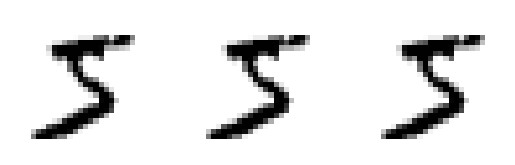

In [6]:
#repeating gray scale image in 3 channel format for compatability with three channel format 
#of the pre-trained network

print('Image shape before:')
print(X.shape)  
X_rgb = np.repeat(X,3,axis=-1)
print('Image shape after:')
print(X_rgb.shape)

print('\nChecking Image:')
#checking repeat image 
for n in range(3):
    ax = plt.subplot(1,3,n+1)
    show_num(X_rgb[0][:,:,n])

In [7]:
#Making test and train sets
X_train, y_train, X_valid, y_valid, X_test, y_test = X_rgb[:60000], y[:60000],X_rgb[60000:65000],y[60000:65000],X_rgb[65000:],y[65000:]

train_data = (X_train, y_train, X_valid, y_valid)
test_data = (X_test, y_test)

## Functions to build, train and evaluate models

A function to build models is developed. By inputting the untrained transfer learning model and the desired size of the input to the transfer learning model, the function will resize the pre-processed images to the desired pixel height and width, build the transfer model, and build a fully connected head. The structure of the fully connected head was optimized in a previous project, <i>Handwritten digit classification with 99.6% accuracy,</i> . 


In [8]:
#function for creating transfer learning model

def build(t_model, input_size):
    #creates transfer model
    transfer_model = t_model(include_top=False, input_shape=(input_size,input_size,3),weights='imagenet')
    transfer_model.trainable = False #freezes model 
    #note: setting trainable to false also sets training to false for BN layers in tf version 2.0 and above

    #creates model with fully connected layers
    print('Building model...')
    inputs = tf.keras.Input(shape=(28,28,3), name='Input')
    x = tf.keras.layers.Resizing(input_size, input_size)(inputs)
    x = transfer_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')(x)
    model = tf.keras.Model(inputs, outputs)

    print(model.summary())

    
    #compile model 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['accuracy'])
    

    return(model)

A function that trains the fully connected head was developed. The layers of the transfer learning model are frozen, and the head is trained with a conservative but effective learning rate of 0.0001. Early stopping with weight saving callbacks are implemented to optimize fit time and save only the weights of the best fitting model.

In [9]:
def train_FC(model, train_data, iters):
    #creating callback to save best weights 
    weight_name = 'weights_'+str(model.layers[2].name)+'_fc.h5'
    save_weights = ModelCheckpoint(weight_name, save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True)

    #training top layers
    print('Training top layers...')
    history = model.fit(train_data[0], train_data[1], validation_data=(train_data[2:]), epochs = iters[0],callbacks=[save_weights, early_stopping],verbose=0)

    #saving weights
    #model.save_weights(weight_name)
    
    return(model, history)

A function to fine tune the full model is developed. All model layers are unfrozen except for batch normalization layers in the transfer model. Batch normalization layers contain two learned and two saved parameters and perform differently in training and instance modes. The saved parameters are the running batch mean and standard deviation, which vary with the data set used. In training mode, the saved parameters are updated, whereas in instance mode they are used without update. It is necessary to keep these layers in instance mode in order to preserve the functionality of the transfer model, as otherwise the pre-trained weights would rapidly diverge and model performance would be quickly destroyed. While the learned parameters of the batch normalization layers can also be fine-tuned, [similar performance](https://arxiv.org/ftp/arxiv/papers/2211/2211.09705.pdf) has been achieved by keeping these parameters frozen. 

The learning rate used (1e-6) is conservative and selected to prevent the transfer weights from diverging too rapidly. Early stopping and weight saving callbacks are used to minimize runtime without sacrificing performance and save only the best performing model's weights.


In [10]:
def fine_tune(model, train_data, iters):
    print('Fine tuning all layers...')
    
    #unfreezing transfer model
    model.layers[2].trainable = True 
    #print(str(model.layers[2].name),str(model.layers[2].trainable))

    #Checking that BN layers are in inference mode and all layers are trainable
    for layer in model.layers[2].layers: 
        if (isinstance(layer, tf.keras.layers.BatchNormalization)):
            layer.trainable = False
        else: assert layer.trainable == True

    #compiling model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(1e-6),
        metrics = ['accuracy'])

    #creatubg callbacks 
    weight_name = 'weights_'+str(model.layers[2].name)+'_ft.h5'
    save_weights = ModelCheckpoint(weight_name, save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True)

    #training model
    history = model.fit(train_data[0], train_data[1], validation_data = (train_data[2:]), epochs = iters[1],callbacks=[save_weights,early_stopping],verbose=0)

    trained_models.append(model)
    #saving weights
    #model.save_weights(weight_name)

    return(model, history)

A function to build and train models is developed utilizing the build and train functions above. This function checks that the proper layers are frozen and unfrozen before fine-tuning and also saves the model's performance.

In [11]:
def build_and_train(t_model, input_size, train_data, iters):
    model = build(t_model, input_size)

    model, history = train_FC(model, train_data, iters)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fc_epochs = len(acc)

    model, history = fine_tune(model, train_data, iters)
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

    scores = (acc, val_acc, loss, val_loss, fc_epochs)
    #pickles scores
    pickle_name = t_model.__name__+'_scores.pkl'
    pickle.dump(scores, open(pickle_name, 'wb'))

    return(model,scores)
    

A function is developed to evaluate each model's performance. This function returns the accuracy of the model on a test data set.

In [12]:
def predict(model, test_data):
    y_pred = model.predict(test_data[0]).argmax(axis=1)
    return accuracy_score(test_data[1],y_pred)

## Models

In [13]:
#fully connected training iterations
fc_iter = 1000

#fine tuning traiing iterations
ft_iter = 100

iters = (fc_iter, ft_iter)

In [14]:
scores = []
trained_models = []
model_names = ['Resnet50','InceptionV3','Mobilenet']

### Resnet50

Resnet 50 is a convolutional neural network that is fifty layers deep and uses skip connections to avoid vanishing or exploding gradients, a common problem in deep neural networks. The output of a previous layer is fed into the output of the next layer using a short cut connection. This keeps the output of the second layer from diverging too rapidly or disappearing as adding the value from the previous output constrains the new output and results in incremental layer performance improvements. The structure of a skip connection is shown below: 

<img src=https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/residualblock.png > <br>
[Jananisbadu, Github](https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/)

The structure of Resnet50 is built using four stages. The first stage is repeated three times, the second stage is repeated four times, the third stage is repeated six times, and the fourth stage is repeated three times. The architecture of Resnet50 is shown below, with the stages shown in yellow, purple, blue and green below:

<img src=https://www.researchgate.net/publication/336805103/figure/fig4/AS:817882309079050@1572009746601/ResNet-50-neural-network-architecture-56.ppm><br>
[Privacy-Constrained Biometric System for Non-Cooperative Users](https://www.researchgate.net/publication/336805103_Privacy-Constrained_Biometric_System_for_Non-Cooperative_Users)

In [15]:
resnet_model, resnet_score = build_and_train(ResNet50,32,train_data,iters)
scores.append(resnet_score)

Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)    

### Inception 

The inception network uses filters of multiple sizes on the same level. The results of these convolutions as well as a max pooling step are concatenated in the inception module: 

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/1*DKjGRDd_lJeUfVlY50ojOA.png><br>
[A Simple Guide to the Versions of the Inception Network](https://miro.medium.com/v2/resize:fit:720/format:webp/1*DKjGRDd_lJeUfVlY50ojOA.png)

The computational cost of this module is reduced by implementing a 1x1 convolution before the 3x3 and 5x5 convolutions. Further in Inception V2, the 3x3 and 5x5 convolutions are broken down into computationally cheaper 1xn and nx1 convolutions to the same effect. This greatly improves the speed of the model. 

The inception model is a deep network and is subject to the problem of vanishing gradients. To combat this, two auxiliary classifiers are added to the middle of the network, and the final loss is computed as the weighted output of all three outputs. In Inception V3, further improvements to the model are made, including factorized 7x7 convolutions, the use of an auxiliary classifier lower in the network, and the addition of more batch normalization layers. The structure of InceptionV3 is shown below: 

<img src=https://cloud.google.com/static/tpu/docs/images/inceptionv3onc--oview.png><br>
[Advanced Guide to Inception v3](https://cloud.google.com/tpu/docs/inception-v3-advanced)





In [16]:
inception_model, inception_score = build_and_train(InceptionV3,75,train_data,iters)
scores.append(inception_score)

Building model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)  

### Mobilenet

Mobilenet uses depthwise convolution to significantly reduce the number of parameters, making it a lightweight alternative to other networks. Depthwise separable convolutions reduce the number of parameters and computation cost involved in convolution operations. Each input channel is convolved with a different kernel and the output is restacked: 

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/1*yG6z6ESzsRW-9q5F_neOsg.png><br>
[A Basic Introduction to Seperable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)

The structure of mobile net is shown below: 

<img src=https://static.hindawi.com/articles/misy/volume-2020/7602384/figures/7602384.fig.001.jpg><br>
[A novel image classification approach via dense-mobilenet models](https://www.hindawi.com/journals/misy/2020/7602384/)

In [17]:
mobilenet_model, mobilenet_score = build_and_train(MobileNet,32,train_data,iters)
scores.append(mobilenet_score)

Building model...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                         

### Visualizing training

The accuracy and loss of the validation and training sets is visualized in the graph below. The black line indicates the end of training the fully connected head and start of model fine tuning.

In [18]:
def model_scores(score):
    acc = score[0]
    val_acc = score[1]
    loss = score[2]
    val_loss = score[3]
    training_epochs = score[4]
    return acc, val_acc, loss, val_loss, training_epochs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

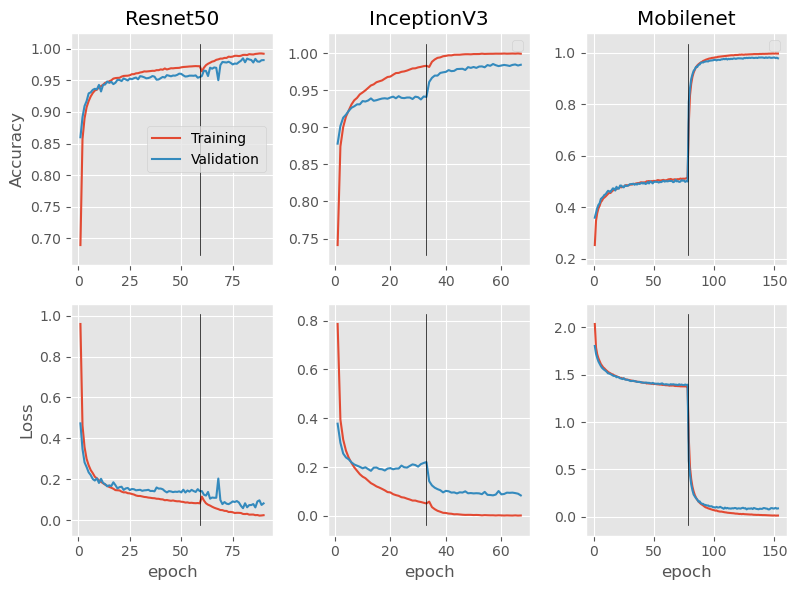

In [43]:
count = 1
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
for score in scores:
    acc, val_acc, loss, val_loss, training_epochs = model_scores(score)
    x_range = range(1,len(acc)+1)

    #selecting legend entry 
    if count == 1:
        label_train = 'Training'
        label_val= 'Validation'
    else: 
        label_train = None
        label_val = None

    plt.subplot(2, 3, count)
    plt.plot(x_range, acc, label=label_train)
    plt.plot(x_range, val_acc, label=label_val)
    #plt.ylim([0.8, 1])
    plt.plot([training_epochs, training_epochs],plt.ylim(), c = 'black',linewidth=.5,label=None)
    plt.legend(frameon=False)
    plt.legend(loc=1)
    if count == 1:
        plt.ylabel('Accuracy')
        plt.legend(frameon=True)

    plt.title(model_names[count-1])

    plt.subplot(2, 3, count+3)
    plt.plot(x_range, loss, label=None)
    plt.plot(x_range, val_loss, label=None)
    #plt.ylim([0, 1.0])
    plt.plot([training_epochs, training_epochs],plt.ylim(), c='k', linewidth=0.5,label=None)
    plt.legend(loc=2,frameon=False)
    plt.xlabel('epoch')
    if count == 1:
        plt.ylabel('Loss')
    
    count +=1

plt.tight_layout()

## Model performance

The accuracy of each model using the test dataset was determined. All models performed well with InceptionV3 slightly outperforming Resnet50 and Mobilenet. The total time required to build and train models is plotted.

In [21]:
test_accuracy = [predict(model, test_data) for model in trained_models]
times = [1571,941,592]  #runtimes in minutes
print(test_accuracy)

157/157 [==============================] - 5s 27ms/step
[0.9912, 0.9932, 0.9912]


In [35]:
pd.DataFrame(test_accuracy,index=model_names, columns=['Accuracy'])

,Accuracy
Resnet50,0.9912
InceptionV3,0.9932
Mobilenet,0.9912


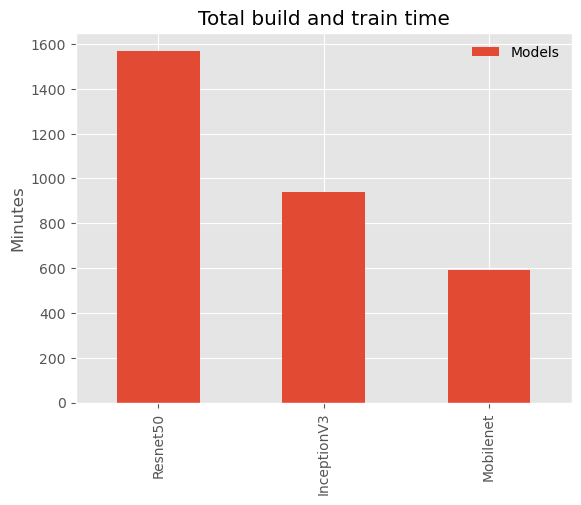

In [60]:
pd.DataFrame(times, index=model_names, columns=['Models']).plot(kind='bar')
plt.title('Total build and train time')
plt.ylabel('Minutes')
plt.legend(frameon=False)

### Conclusions

All of the transfer models performed reasonably well with the test set accuracy ranging from 99.12-99.32%. After finetuning, InceptionV3 performed better than Mobilenet and Resnet50. Without finetuning the transfer model, InceptionV3 and Resnet50 significantly outperform Mobilenet. However, the accuracy of Mobilenet quickly and drastically improves with only slight finetuning. If time is an important consideration, Mobilenet should be used as even though more training epochs are required to fully optimize performance, training time is significantly reduced with only a slight decrease in accuracy.

These models do not out perform a simple small convolutional neural network with careful data augmentation, which reached 99.6% accuracy and trained in ~2 minutes in a previous project, <i>Handwritten digit classification with 99.6% accuracy,</i>. This highlights the importance of data augmentation in improving model accuracy but is also likely the case due to the simplicity of our images. In applications with more complex images, the additional ability of these deeper networks to identify patterns is likely to result in improved performance.